# Facial Expression Recognition using MobileNetV2 with Fine-Tuning


## Project Overview

This project implements a **Facial Expression Recognition Plus (FERPlus)** system using **transfer learning** with a **MobileNetV2** backbone.  
The model classifies facial expressions into **8 emotion categories** using a fine-tuned convolutional neural network trained on the FERPlus dataset.


## Dependencies

In [ ]:
import os
import warnings
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2026-01-10 23:37:51.704515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-10 23:37:52.058361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 23:37:53.349937: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Environment Configuration

TensorFlow logging is minimized for cleaner output.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
warnings.filterwarnings("ignore")

In [3]:
tf.__version__

'2.20.0'

## Dataset Structure
The project uses the FERPlus dataset organized into three directories:
- `FERPlus/train/`
- `FERPlus/test/` 
- `FERPlus/validation/`


In [4]:
train_dir = "FERPlus/train"
test_dir = "FERPlus/test"
val_dir = "FERPlus/validation"

In [5]:
# -------------- load the data -------------- #
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=8,
    image_size=(112, 112)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    batch_size=8,
    image_size=(112, 112)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=8,
    image_size=(112, 112)
)

Found 66379 files belonging to 8 classes.


I0000 00:00:1768077477.640550    4707 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 8341 files belonging to 8 classes.
Found 800 files belonging to 8 classes.


### Dataset Classes
The model classifies images into 8 emotion categories:

In [6]:
label_to_class = {i: name for i, name in enumerate(train_ds.class_names)}

print("Label : Class Name")
print("-------------------")
for label, name in label_to_class.items():
    print(f"{label}     : {name}")

Label : Class Name
-------------------
0     : angry
1     : contempt
2     : disgust
3     : fear
4     : happy
5     : neutral
6     : sad
7     : suprise


In [7]:
labels = list(label_to_class.keys())
class_names = list(label_to_class.values())

## Data Exploration & Visualization


### 1. Sample Visualization

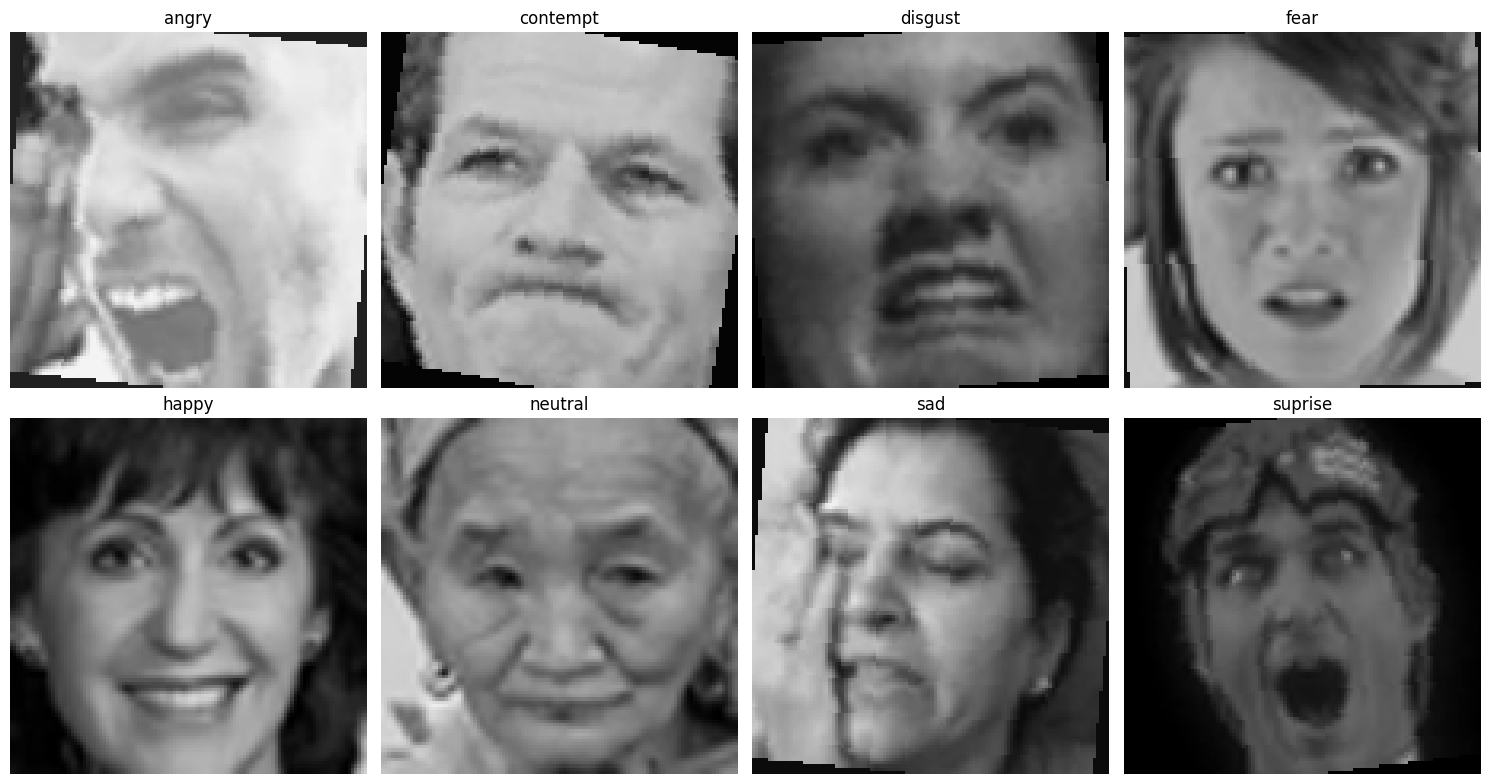

In [8]:
plt.figure(figsize=(15, 8))
class_names = train_ds.class_names 

# Find and display one image from each class
found_classes = set()
count = 0

# Iterate through the dataset until we find an example of every class
for images, labels in train_ds.take(10): # Take a few batches
    for i in range(len(labels)):
        class_idx = labels[i].numpy()
        if class_idx not in found_classes:
            found_classes.add(class_idx)
            
            # Subplot index starts at 1
            plt.subplot(2, 4, class_idx + 1)
            
            # Display the image (it's 112x112 based on your code)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[class_idx])
            plt.axis("off")
            
            count += 1
        
        # Stop once we have all 8 classes
        if count == len(class_names):
            break
    if count == len(class_names):
        break

plt.tight_layout()
plt.show()

### 2. Class Balance Analysis

In [9]:
# --- Class Balance Visualization for Train, Validation, and Test Sets ---
def plot_class_balance(dataset, dataset_name):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    for i, count in enumerate(class_counts.values()):
        plt.text(i, count + 2, str(count), ha='center', va='bottom')
    plt.show()


2026-01-10 23:38:01.729638: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


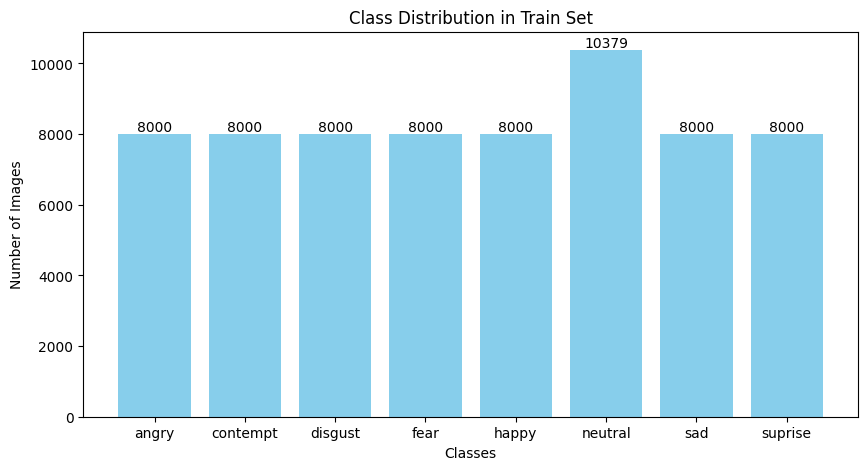

2026-01-10 23:38:02.145223: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


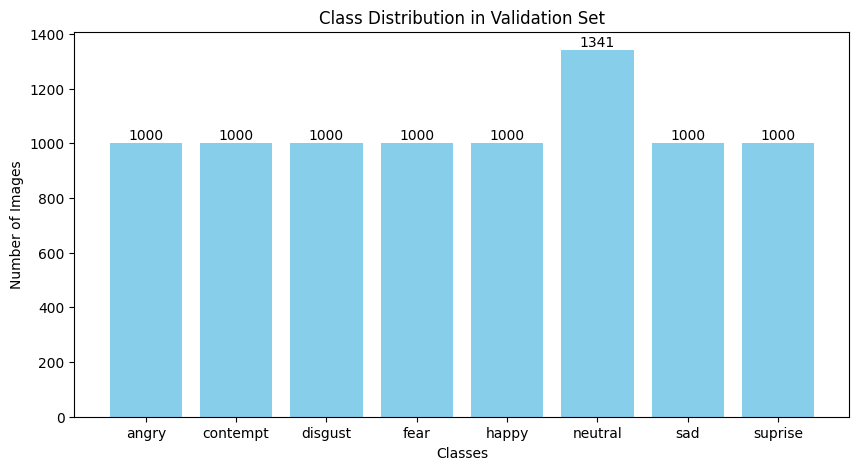

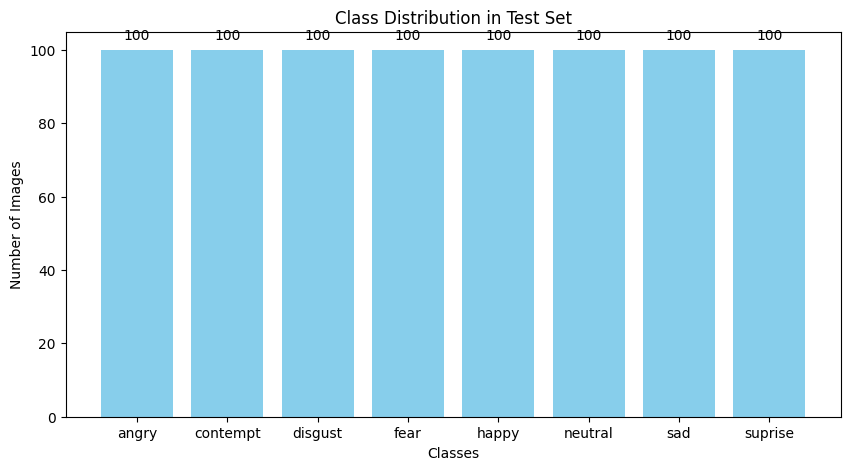

In [10]:
# Display class balance for each dataset
plot_class_balance(train_ds, "Train")
plot_class_balance(val_ds, "Validation")
plot_class_balance(test_ds, "Test")

## Data Pipeline Optimization
Prefetching for Performance

In [11]:
# -------------- Speed up data loading with prefetch -------------- #
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation
To improve model generalization and prevent overfitting:

In [12]:
# ------------------- Data Augmentation ------------------- #
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.5), # Zoom in/out by 50%
    layers.RandomContrast(0.1), # Adjust contrast
    layers.RandomTranslation(0.1, 0.1), # Translate images 10% in x and y
])

## Model Architecture
- `Base Model:` MobileNetV2
- `Input:` 112×112×3 RGB images

- `Weights:` Pre-trained on ImageNet

- `Top Layers:` Excluded for custom classification head

- `Trainable:` Initially frozen during feature extraction phase

In [13]:
# ------------------- Load MobileNetV2 ------------------- #
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(112, 112, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

### Custom Classification Head

In [14]:
# ------------------- CNN model ------------------- #
model = models.Sequential([
    layers.Rescaling(1./255),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),

    # Dense block 1
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Dense block 2
    layers.Dense(384, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    
    # Dense block 3
    layers.Dense(320, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Dense block 4
    layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(8, activation="softmax")
])

In [15]:
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

## Training Strategy

### Callbacks Configuration
- **EarlyStopping**: Monitors validation loss with 3-4 patience
- **ReduceLROnPlateau**: Reduces learning rate when validation loss plateaus
- **ModelCheckpoint**: Saves best model weights during training

In [ ]:
# -------------------- Callbacks --------------------
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
checkpoint_ft = ModelCheckpoint(
    "models/best_model_finetune_v1.weights.h5", 
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


### Two-Phase Training

#### Phase 1: Feature Extraction
- **Epochs**: 10
- **Base Model**: Frozen
- **Learning Rate**: Default Adam (0.001)
- **Goal**: Train only the custom classification head

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint_ft]
)

Epoch 1/10


2026-01-10 23:38:08.420729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


8295/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2585 - loss: 3.1770
Epoch 1: val_loss improved from None to 1.99288, saving model to best_model_finetune_v1.weights.h5
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 85s 10ms/step - accuracy: 0.2938 - loss: 2.7197 - val_accuracy: 0.3833 - val_loss: 1.9929 - learning_rate: 0.0010
Epoch 2/10
8295/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3287 - loss: 2.0903
Epoch 2: val_loss did not improve from 1.99288
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.3242 - loss: 2.0713 - val_accuracy: 0.3334 - val_loss: 2.0266 - learning_rate: 0.0010
Epoch 3/10
8294/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3286 - loss: 2.0256
Epoch 3: val_loss improved from 1.99288 to 1.81874, saving model to best_model_finetune_v1.weights.h5
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.3273 - loss: 2.0148 - val_accuracy: 0.3991 - val_loss: 1.8187 - learning_rate: 0.0010
Epoch 4/10
8296/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accurac

In [ ]:
model.load_weights("models/best_model_finetune_v1.weights.h5")
base_model = model.layers[2]

#### Phase 2: Fine-Tuning
- **Epochs**: 20
- **Base Model**: Partially unfrozen (last 100 layers trainable)
- **Learning Rate**: Reduced to 1e-5
- **Goal**: Fine-tune both base model and classification head

In [19]:
# -------------------- Fine-tuning --------------------
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_stop_ft = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
reduce_lr_ft = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
checkpoint_ft = ModelCheckpoint("models/best_model_finetune_v1.h5", monitor="val_loss", save_best_only=True, verbose=1)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop_ft, reduce_lr_ft, checkpoint_ft]
)

Epoch 1/20
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3090 - loss: 1.9408
Epoch 1: val_loss improved from None to 1.54477, saving model to best_model_finetune_v1.h5
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 253s 29ms/step - accuracy: 0.3486 - loss: 1.8574 - val_accuracy: 0.4956 - val_loss: 1.5448 - learning_rate: 1.0000e-05
Epoch 2/20
8297/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4236 - loss: 1.7029
Epoch 2: val_loss improved from 1.54477 to 1.35426, saving model to best_model_finetune_v1.h5
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 257s 31ms/step - accuracy: 0.4398 - loss: 1.6644 - val_accuracy: 0.5679 - val_loss: 1.3543 - learning_rate: 1.0000e-05
Epoch 3/20
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4861 - loss: 1.5607
Epoch 3: val_loss improved from 1.35426 to 1.23029, saving model to best_model_finetune_v1.h5
8298/8298 ━━━━━━━━━━━━━━━━━━━━ 263s 32ms/step - accuracy: 0.4935 - loss: 1.5382 - val_accuracy: 0.6094 - val_loss: 1.2303 - learning_rate: 1.0000e-05
Epoc

## Model Evaluation

- **Classification Report**: Precision, recall, F1-score per class
- **Confusion Matrix**: Visual representation of predictions vs actual labels
- **Accuracy Curves**: Training vs validation accuracy over epochs
- **Loss Curves**: Training vs validation loss over epochs

### Classification Report
Provides detailed performance metrics for each emotion class including precision, recall, and F1-score.

In [ ]:
# -------------------- Evaluation --------------------
y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_to_class.values()))

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.67      0.66       100
    contempt       0.83      0.57      0.67       100
     disgust       0.76      0.65      0.70       100
        fear       0.73      0.75      0.74       100
       happy       0.87      0.84      0.85       100
     neutral       0.50      0.77      0.61       100
         sad       0.47      0.51      0.49       100
     suprise       0.86      0.68      0.76       100

    accuracy                           0.68       800
   macro avg       0.71      0.68      0.68       800
weighted avg       0.71      0.68      0.68       800



2026-01-11 01:06:25.166335: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Confusion Matrix
Heatmap visualization showing model predictions versus true labels across all 8 classes.

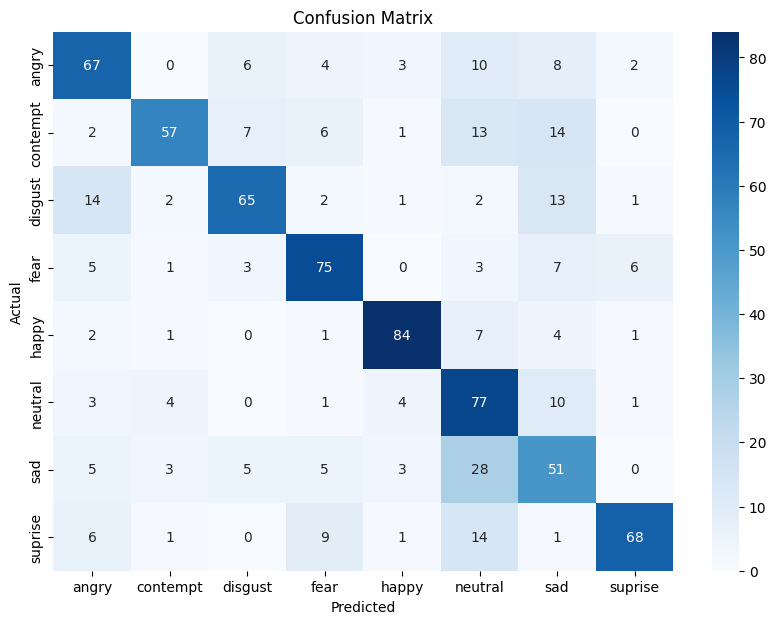

In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_class.values(), yticklabels=label_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Accuracy Curves
Line plot comparing training and validation accuracy across epochs during fine-tuning phase.

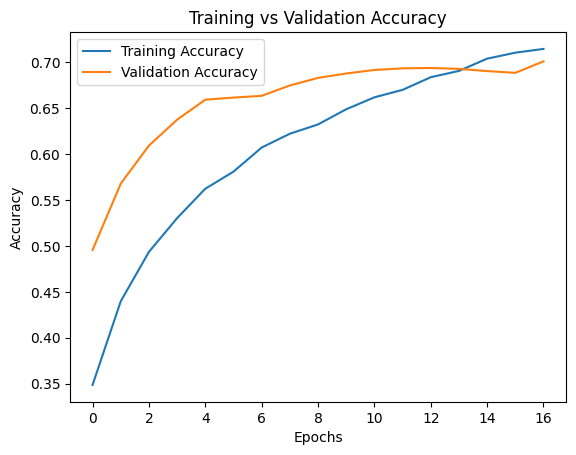

In [23]:

plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

### Loss Curves
Line plot comparing training and validation loss across epochs during fine-tuning phase.

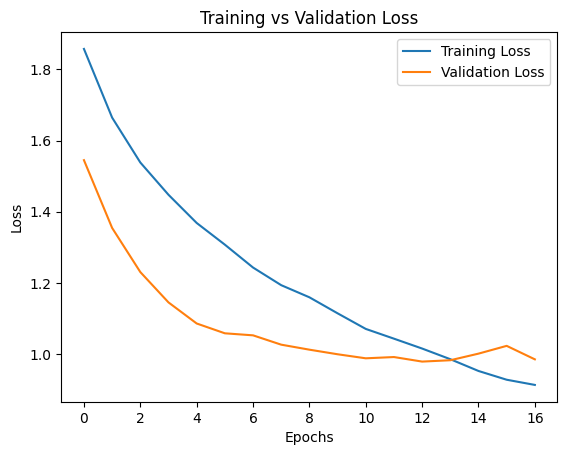

In [24]:
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()